In [4]:
InteractionsFileCaptureC='/srv/scratch/mtaranov/CaptureC_ChicagoCalls/CaptureC_SC_bait-bait.bed.gz'
#InteractionsFileHiC100='/srv/gsfs0/projects/kundaje/users/mtaranov/projects/dynamic3D/ContactsAfterIC/P-P_from_HiC/output/PP_SC_RE100.bed.gz'
#InteractionsFileHiC20='/srv/gsfs0/projects/kundaje/users/mtaranov/projects/dynamic3D/ContactsAfterIC/P-P_from_HiC/output/PP_SC_RE20.bed.gz'
#InteractionsFileHiC5='/srv/gsfs0/projects/kundaje/users/mtaranov/projects/dynamic3D/ContactsAfterIC/P-P_from_HiC/output/PP_SC_RE5.bed.gz'
PromoterFile='/srv/scratch/mtaranov/HindIII/PromoterCapture_Digest_Human_HindIII_baits_ID.bed'
PROJDIR='/users/mtaranov/NN_thres5max_datasets/'
DATAJDIR='/users/mtaranov/NN_thres5max_datasets/dist_matched_chr/'
DATAJDIR2='/users/mtaranov/NN_thres5max_datasets/no_dist_matched_chr/'

In [5]:
features_path='/srv/scratch/mtaranov/peaks_at_promoters/output_thres5_max/'
atac=features_path+'atac'
#TFs
ctcf=features_path+'CTCF'
pol3=features_path+'PolII'
TP63=features_path+'TP63'
LSD1=features_path+'LSD1'
#histone
H3K27ac=features_path+'H3K27ac'
H3K27me3=features_path+'H3K27me3'
H3K4me1=features_path+'H3K4me1'
H3K4me3=features_path+'H3K4me3'
H3K9ac=features_path+'H3K9ac'

In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy.stats.mstats import mquantiles
import scipy.stats as ss
import math
import scipy.linalg
import itertools
import copy
import random
import gzip
from sets import Set
#reload(rcca)
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, auc, roc_curve
from sklearn import preprocessing
from scipy.spatial.distance import pdist, squareform
import networkx as nx

from utils_data_process import printMatrix, set_diag_to_value, binarize, binarize_w_unlabeled, demean, zscore
from utils_data_process import shuffle_nodes, train_vali_test, build_distance_for_node, BuildMatrix, get_features
from utils_data_process import get_data_labels, remove_unlabeled, concatenate_chrs, get_pairs_distance_matched, impose_dist_constrains, count_nodes_and_contacts

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
labels_score = BuildMatrix(PromoterFile, InteractionsFileCaptureC)

non-unique entries in CaptureC file(bait1-bait2/bait2-bait1):  1237741.0   0.49244938606 %
unique entries in CaptureC file(bait1-bait2/bait2-bait1):  1275697.0   0.50755061394 %


46.6549268544
(2272, 2272)
Limit: 46.6549268544


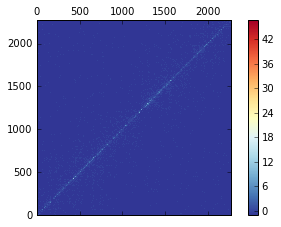

In [24]:
printMatrix(labels_score['chr1'], '', 1, 1, title='')

31.5660281516
(300, 300)
Limit: 31.5660281516


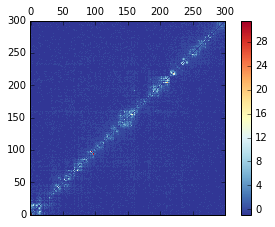

In [25]:
subset=labels_score['chr1'][[i for i in range(300)]][:, [i for i in range(300)]]
printMatrix(subset, '', 1, i, title='')

1.0
(300, 300)
Limit: 1.0


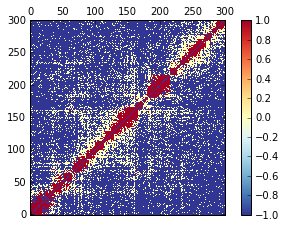

In [26]:
subset=labels_score['chr1'][[i for i in range(300)]][:, [i for i in range(300)]]
printMatrix(binarize(subset), '', 1, i, title='')

1.0
(300, 300)
Limit: 1.0


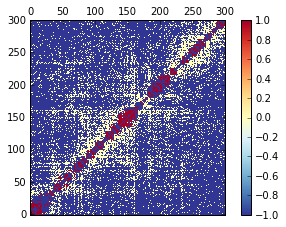

In [27]:
subset=labels_score['chr1'][[i for i in range(300)]][:, [i for i in range(300)]]
printMatrix(binarize_w_unlabeled(subset, 1), '', 1, i, title='')

1.0
(300, 300)
Limit: 1.0


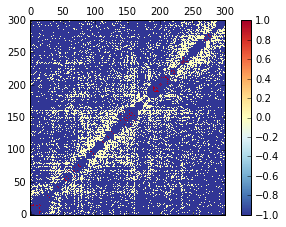

In [28]:
subset=labels_score['chr1'][[i for i in range(300)]][:, [i for i in range(300)]]
printMatrix(binarize_w_unlabeled(subset, 5), '', 1, i, title='')

Average value with zeros:  21.9245984551
Average q-value w/o zeros:  33.3418257631


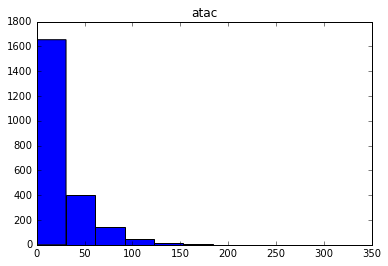

Average value with zeros:  30.8321433979
Average q-value w/o zeros:  63.798387796


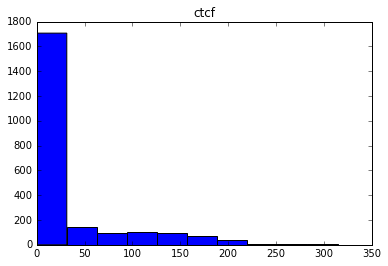

Average value with zeros:  18.2601188732
Average q-value w/o zeros:  35.2780527891


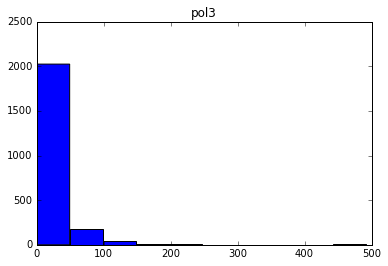

Average value with zeros:  6.97454184859
Average q-value w/o zeros:  17.6657291862


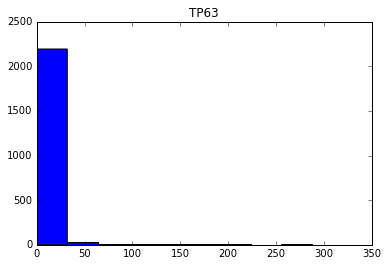

Average value with zeros:  0.828355180458
Average q-value w/o zeros:  9.04818735577


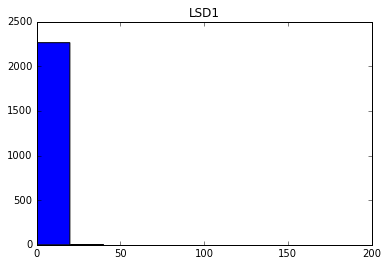

Average value with zeros:  29.1659232835
Average q-value w/o zeros:  55.7316885618


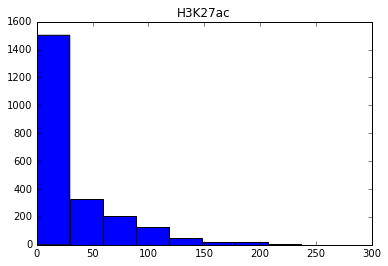

Average value with zeros:  3.3275984419
Average q-value w/o zeros:  16.0175925


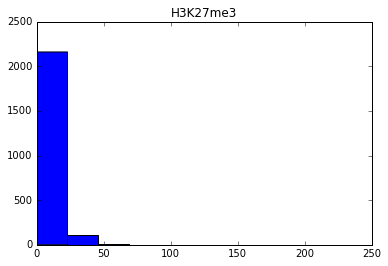

Average value with zeros:  10.5938546083
Average q-value w/o zeros:  15.7418166579


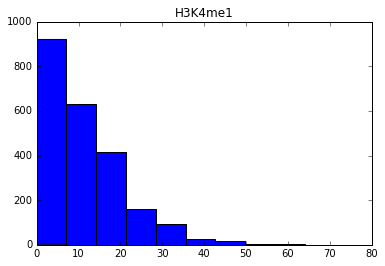

Average value with zeros:  105.891611549
Average q-value w/o zeros:  179.809971181


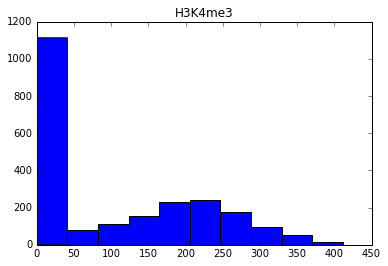

Average value with zeros:  16.4996693574
Average q-value w/o zeros:  30.6268372386


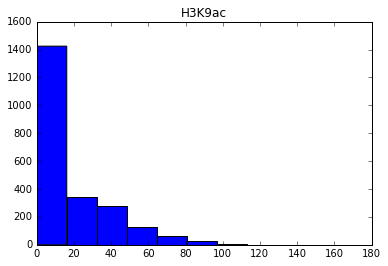

In [29]:
VectorATAC=get_features(PromoterFile, atac, 'atac')

VectorCTCF=get_features(PromoterFile, ctcf, 'ctcf')
VectorPOL3=get_features(PromoterFile, pol3, 'pol3')
VectorTP63=get_features(PromoterFile, TP63, 'TP63')
VectorLSD1=get_features(PromoterFile, LSD1, 'LSD1')

VectorH3K27ac=get_features(PromoterFile, H3K27ac, 'H3K27ac')
VectorH3K27me3=get_features(PromoterFile, H3K27me3, 'H3K27me3')
VectorH3K4me1=get_features(PromoterFile, H3K4me1, 'H3K4me1')
VectorH3K4me3=get_features(PromoterFile, H3K4me3, 'H3K4me3')
VectorH3K9ac=get_features(PromoterFile, H3K9ac, 'H3K9ac')

In [30]:
distance_for_node = build_distance_for_node(PromoterFile)

In [31]:
FeatureVector_wo_dist = {}
FeatureVector = {}
for chr in VectorATAC:
    if chr != 'chrY':
        FeatureVector_wo_dist[chr] = demean(np.vstack((VectorATAC[chr], VectorCTCF[chr], VectorPOL3[chr], VectorTP63[chr], VectorLSD1[chr], VectorH3K27ac[chr], VectorH3K27me3[chr], VectorH3K4me1[chr], VectorH3K4me3[chr], VectorH3K9ac[chr])).T)
        FeatureVector[chr] = np.concatenate((FeatureVector_wo_dist[chr], distance_for_node[chr]), axis=1)
#FeatureVectorDistance = demean(np.vstack((VectorATAC, VectorCTCF, VectorPOL3, VectorTP63, VectorLSD1, VectorH3K27ac, VectorH3K27me3, VectorH3K4me1, VectorH3K4me3, VectorH3K9ac, distance_for_node)).T)

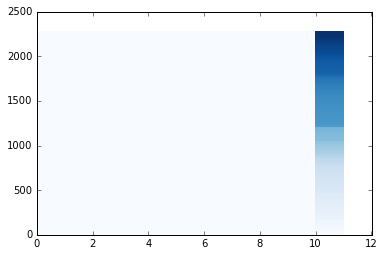

In [32]:
fig, ax = plt.subplots()
heatmap = ax.pcolor(FeatureVector['chr1'], cmap=plt.cm.Blues)
#heatmap = ax.pcolor(DistanceFeatureVectorK, cmap=plt.cm.Blues)

In [33]:
data, labels, indx  = get_data_labels(FeatureVector, labels_score)

In [34]:
indx['chr1'].shape

(2579856, 3)

In [35]:
data_wo_unlbd_at_10={}
labels_wo_unlbd_at_10={}
indx_wo_unlbd_at_10={}
for chr in data:
    data_wo_unlbd_at_10[chr], labels_wo_unlbd_at_10[chr], indx_wo_unlbd_at_10[chr]= remove_unlabeled(data[chr], binarize_w_unlabeled(labels[chr], 10), indx[chr])

In [92]:
indx_wo_unlbd_at_10['chr1'].shape

(152283, 3)

In [93]:
test_data_dict = {}
test_labels_dict = {}
test_indx_dict = {}
for chr in ['chr1', 'chr2', 'chr3']:
    test_data_dict.update({chr:data_wo_unlbd_at_10[chr]})
    test_labels_dict.update({chr:labels_wo_unlbd_at_10[chr]})
    test_indx_dict.update({chr:indx_wo_unlbd_at_10[chr]})
    
vali_data_dict = {}
vali_labels_dict = {}
vali_indx_dict = {}
for chr in ['chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15']:
    vali_data_dict.update({chr:data_wo_unlbd_at_10[chr]})
    vali_labels_dict.update({chr:labels_wo_unlbd_at_10[chr]})
    vali_indx_dict.update({chr:indx_wo_unlbd_at_10[chr]})

other_chrs = []
for i in range(22):
    if (i!=0 and i!=1 and i!=2 and i!=8 and i!=9 and i!=10 and i!=11 and i!=12 and i!=13 and i!=14):
        other_chrs.append('chr'+str(i+1)) 

train_data_dict = {}
train_labels_dict = {}
train_indx_dict = {}
for chr in other_chrs:
    train_data_dict.update({chr:data_wo_unlbd_at_10[chr]})
    train_labels_dict.update({chr:labels_wo_unlbd_at_10[chr]})
    train_indx_dict.update({chr:indx_wo_unlbd_at_10[chr]})

In [94]:
test_indx_dict['chr1'].shape

(152283, 3)

In [95]:
def concatenate_chrs(data, labels, indx):
    data_to_concatenate = []
    labels_to_concatenate = []
    indx_to_concatenate = []
    for chr in data:
        data_to_concatenate.append(data[chr])
        labels_to_concatenate.append(labels[chr])
        indx_to_concatenate.append(indx[chr])
    return np.concatenate(data_to_concatenate, axis=0), np.concatenate(labels_to_concatenate, axis=0), np.concatenate(indx_to_concatenate, axis=0)

In [96]:
test_set_thres_10, labels_test_thres_10, indx_test_thres_10 = concatenate_chrs(test_data_dict, test_labels_dict, test_indx_dict)
train_set_thres_10, labels_train_thres_10, indx_train_thres_10 = concatenate_chrs(train_data_dict, train_labels_dict, train_indx_dict)
vali_set_thres_10, labels_vali_thres_10, indx_vali_thres_10 = concatenate_chrs(vali_data_dict, vali_labels_dict, vali_indx_dict)

In [97]:
indx_test_thres_10.shape

(303288, 3)

In [98]:
min_dist=10000
max_dist=2000000
dist_step=10000
class_imbalance=1
X_test_distance_matched_at_10, y_test_distance_matched_at_10, indx_test_distance_matched_at_10 = get_pairs_distance_matched(test_set_thres_10, labels_test_thres_10,indx_test_thres_10, min_dist, max_dist, dist_step, class_imbalance)
X_train_distance_matched_at_10, y_train_distance_matched_at_10, indx_train_distance_matched_at_10= get_pairs_distance_matched(train_set_thres_10, labels_train_thres_10, indx_train_thres_10, min_dist, max_dist, dist_step, class_imbalance)
X_valid_distance_matched_at_10, y_valid_distance_matched_at_10, indx_valid_distance_matched_at_10 = get_pairs_distance_matched(vali_set_thres_10, labels_vali_thres_10, indx_vali_thres_10, min_dist, max_dist, dist_step, class_imbalance)

distance window:  [ 10000 , 20000 ]
number of pos at distance=: 27
number of neg at distance=: 0
labels at dist:  (0, 1)
data at dist:  (0, 11, 2)
indx at dist:  (0, 3)
distance window:  [ 20000 , 30000 ]
number of pos at distance=: 23
number of neg at distance=: 0
labels at dist:  (0, 1)
data at dist:  (0, 11, 2)
indx at dist:  (0, 3)
distance window:  [ 30000 , 40000 ]
number of pos at distance=: 9
number of neg at distance=: 0
labels at dist:  (0, 1)
data at dist:  (0, 11, 2)
indx at dist:  (0, 3)
distance window:  [ 40000 , 50000 ]
number of pos at distance=: 11
number of neg at distance=: 0
labels at dist:  (0, 1)
data at dist:  (0, 11, 2)
indx at dist:  (0, 3)
distance window:  [ 50000 , 60000 ]
number of pos at distance=: 10
number of neg at distance=: 1
labels at dist:  (2, 1)
data at dist:  (2, 11, 2)
indx at dist:  (2, 3)
distance window:  [ 60000 , 70000 ]
number of pos at distance=: 10
number of neg at distance=: 0
labels at dist:  (0, 1)
data at dist:  (0, 11, 2)
indx at d

In [99]:
print "in all chrs:"
y_at_10=np.concatenate((y_train_distance_matched_at_10, y_valid_distance_matched_at_10, y_test_distance_matched_at_10), axis=0)
print "pos at thres=10: ", np.where(y_at_10 > 0)[0].shape[0], " | train: ", np.where(y_train_distance_matched_at_10 > 0)[0].shape[0], "vali:",np.where(y_valid_distance_matched_at_10 > 0)[0].shape[0], "test:",np.where(y_test_distance_matched_at_10 > 0)[0].shape[0] 
print "neg at thres=10: ", np.where(y_at_10 == 0)[0].shape[0], " | train: ", np.where(y_train_distance_matched_at_10 == 0)[0].shape[0], "vali:",np.where(y_valid_distance_matched_at_10 == 0)[0].shape[0], "test:",np.where(y_test_distance_matched_at_10 == 0)[0].shape[0]
print "total: ", y_at_10.shape[0]

in all chrs:
pos at thres=10:  1122  | train:  628 vali: 269 test: 225
neg at thres=10:  1122  | train:  628 vali: 269 test: 225
total:  2244


In [100]:
count_nodes_and_contacts(indx_train_distance_matched_at_10, indx_valid_distance_matched_at_10, indx_test_distance_matched_at_10)

Number of distance-matched links in each chr:
chr1: 99
chr2: 109
chr3: 242
chr4: 45
chr5: 298
chr6: 219
chr7: 421
chr8: 64
chr9: 29
chr10: 47
chr11: 102
chr12: 152
chr13: 149
chr14: 35
chr15: 24
chr16: 56
chr17: 80
chr18: 8
chr19: 14
chr20: 26
chr21: 12
chr22: 13
chr23: 0
Total: 2244
Number of nodes in each chr:
chr1: 161
chr2: 177
chr3: 321
chr4: 79
chr5: 194
chr6: 257
chr7: 382
chr8: 108
chr9: 51
chr10: 77
chr11: 159
chr12: 224
chr13: 192
chr14: 52
chr15: 39
chr16: 82
chr17: 113
chr18: 13
chr19: 27
chr20: 44
chr21: 18
chr22: 24
chr23: 0
Total: 2794


In [101]:
np.save(DATAJDIR+'X_train_thres_10_chr.npy', X_train_distance_matched_at_10) 
np.save(DATAJDIR+'X_valid_thres_10_chr.npy', X_valid_distance_matched_at_10) 
np.save(DATAJDIR+'X_test_thres_10_chr.npy', X_test_distance_matched_at_10) 
np.save(DATAJDIR+'y_train_thres_10_chr.npy', y_train_distance_matched_at_10)
np.save(DATAJDIR+'y_valid_thres_10_chr.npy', y_valid_distance_matched_at_10)
np.save(DATAJDIR+'y_test_thres_10_chr.npy', y_test_distance_matched_at_10)

np.save(DATAJDIR+'indx_train_thres_10_chr.npy', indx_train_distance_matched_at_10)
np.save(DATAJDIR+'indx_valid_thres_10_chr.npy', indx_valid_distance_matched_at_10)
np.save(DATAJDIR+'indx_test_thres_10_chr.npy', indx_test_distance_matched_at_10)
#d = np.load('labels_test_all.npy')

## write out chr1 [10kb-2Mb] w/0 ditance matching  

In [103]:
np.save(DATAJDIR2+'X_train_thres_10_chr_noDM.npy', train_set_thres_10) 
np.save(DATAJDIR2+'X_valid_thres_10_chr_noDM.npy', vali_set_thres_10) 
np.save(DATAJDIR2+'X_test_thres_10_chr_noDM.npy', test_set_thres_10) 
np.save(DATAJDIR2+'y_train_thres_10_chr_noDM.npy', labels_train_thres_10) 
np.save(DATAJDIR2+'y_valid_thres_10_chr_noDM.npy', labels_vali_thres_10) 
np.save(DATAJDIR2+'y_test_thres_10_chr_noDM.npy', labels_test_thres_10) 
np.save(DATAJDIR2+'indx_train_thres_10_chr_noDM.npy', indx_train_thres_10) 
np.save(DATAJDIR2+'indx_valid_thres_10_chr_noDM.npy', indx_vali_thres_10) 
np.save(DATAJDIR2+'indx_test_thres_10_chr_noDM.npy', indx_test_thres_10)